# بسم الله الرحمن الرحيم

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tifffile as tiff
import tensorflow as tf
import zipfile
from PIL import Image

In [2]:
with zipfile.ZipFile('/content/segmentation water.zip' , 'r') as file :
  file.extractall('/content/water_segmentation')

# load the dataset and there labels

In [3]:

def load_data_labels(data_path):

  image_path = os.path.join(data_path , 'images')
  label_path = os.path.join(data_path , 'labels')


  images = []
  labels = []

  for filename in os.listdir(image_path):
    image = os.path.join(image_path , filename)
    images.append((image , int(filename.split('.')[0])))

  for filename in os.listdir(label_path):
    if '_' in filename:
        continue
    image = os.path.join(label_path , filename)
    labels.append((image , int(filename.split('.')[0])))

  images.sort(key=lambda x:x[1])
  labels.sort(key=lambda x:x[1])

  final_images = []
  final_labels = []

  for i in range(len(images)):
    image = tiff.imread(images[i][0])
    final_images.append(image)

    label = Image.open(labels[i][0])
    final_labels.append(label)

  return final_images , final_labels

file_path = '/content/water_segmentation/data'

d_img , d_label =  load_data_labels(file_path)

d_img = tf.convert_to_tensor(np.array(d_img))
d_label = tf.convert_to_tensor(np.array(d_label))


print(f"Loaded {len(d_img)} images with shape {d_img[0].shape} and {len(d_label)} labels with shape {d_label[0].shape}")

Loaded 306 images with shape (128, 128, 12) and 306 labels with shape (128, 128)


# visualize the channels of every image and ground truth

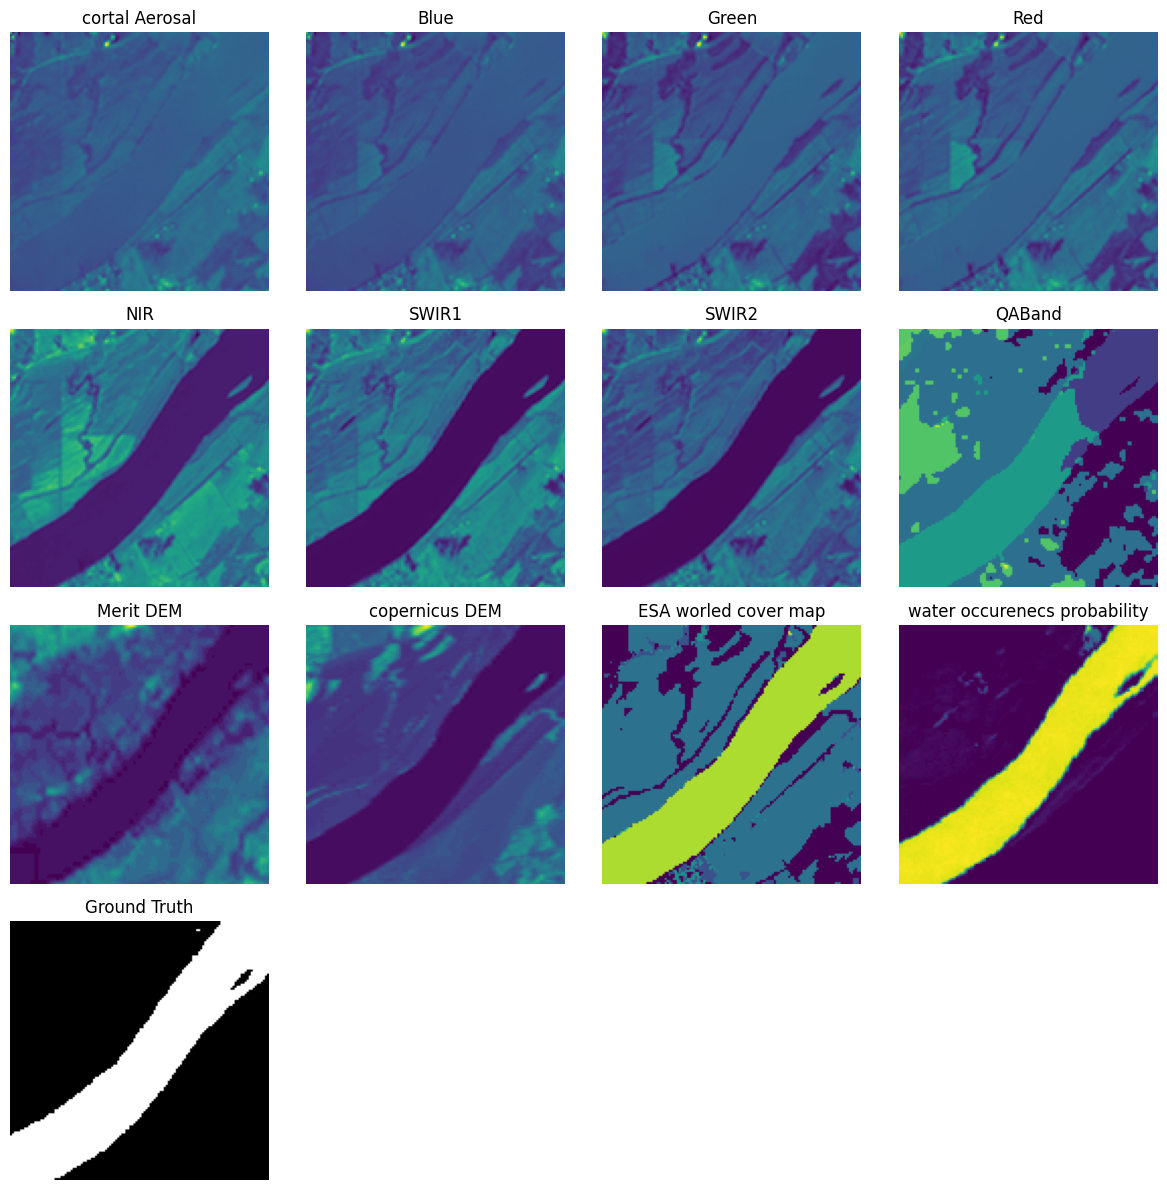

In [4]:

name_of_channels = ['cortal Aerosal' , 'Blue' , 'Green' , 'Red' , 'NIR' , 'SWIR1' , 'SWIR2' , 'QABand' , 'Merit DEM' ,
                    'copernicus DEM' , 'ESA worled cover map' ,'water occurenecs probability']
plt.figure(figsize=(12, 12))
for i in range(d_img.shape[3]):
  plt.subplot(4, 4, i + 1)  # Adjusted subplot grid and index
  plt.imshow(d_img[305, :, :, i]) # Assuming channels are grayscale
  plt.title(f'{name_of_channels[i]}')
  plt.axis('off')

# Display the ground truth label
plt.subplot(4, 4, 13) # Place the ground truth in the next available subplot
plt.imshow(d_label[305, :, :], cmap='gray') # Assuming labels are grayscale
plt.title('Ground Truth')
plt.axis('off')

plt.tight_layout()
plt.show()

# Preprocessing

In [5]:
# normalization

def apply_normalization(channel):
  # Ensure channel is a float32 tensor for calculation
  channel = tf.cast(channel, tf.float32)
  min_val = tf.reduce_min(channel)
  max_val = tf.reduce_max(channel)

  # Avoid division by zero if max_val is equal to min_val
  if tf.equal(max_val, min_val):
      return tf.zeros_like(channel) # Or return channel if no change is desired
  return (channel - min_val) / (max_val - min_val)

normalized_channels = []
for i in range(d_img.shape[3]):
  normalized_channel = apply_normalization(d_img[:,:,:,i])
  normalized_channels.append(normalized_channel)

# Stack the normalized channels back into a single tensor
d_img = tf.stack(normalized_channels, axis=-1)


# You can check the min and max values of the normalized tensor
print(f"Minimum value after normalization: {tf.reduce_min(d_img)}")
print(f"Maximum value after normalization: {tf.reduce_max(d_img)}")

Minimum value after normalization: 0.0
Maximum value after normalization: 1.0


In [6]:
# create NDWI

green = tf.cast(d_img[:,:,:,2], tf.float32)
nir = tf.cast(d_img[:,:,:,4], tf.float32)

NDWI = (green - nir) / (green + nir)


# Expand dimensions of NDWI to match d_img for concatenation
NDWI = tf.expand_dims(NDWI, axis=-1)

# Concatenate the original image tensor with the NDWI channel
d_img = tf.concat([d_img, NDWI], axis=-1)

# bonus --> (create another channel by sobel edge detection)

print(d_img.shape)

(306, 128, 128, 13)


In [7]:
# choose the suitable channels(filter channels)

'''
i will choose those channels :
- Blue (1)
- Green (2)
- NIR (4)
- SWIR1 (5)
- SWIR2 (6)
- copernicus DEM (9)
- ESA worlded cover map(10)
- NDWI (12)
'''

# Convert the list of indices to a TensorFlow tensor
selected_channels_indices = tf.constant([1, 2, 4, 5, 6, 9, 10, 12], dtype=tf.int32)

d_img = tf.gather(d_img, selected_channels_indices, axis=-1)

print(d_img.shape)
print(d_img.dtype)

(306, 128, 128, 8)
<dtype: 'float32'>


# Data Augmentation

In [8]:
# Data augmentation
import albumentations as A

augment_steps = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.VerticalFlip(p=0.5),
        # Elastic deformation
        # A.ElasticTransform(
        # alpha=1,
        # sigma=50,
        # alpha_affine=50,
        # interpolation=1,
        # border_mode=0,
        # always_apply=False,
        # p=0.5
        # )
    ]
)

In [9]:
# check from hight and width

print(d_img.shape)
print(d_label.shape)

# Note : albumentation expected dimention like (W , H , C) , so i need to expand the dim of labels

d_label = tf.expand_dims(d_label , axis = -1)

print(d_label.shape)

(306, 128, 128, 8)
(306, 128, 128)
(306, 128, 128, 1)


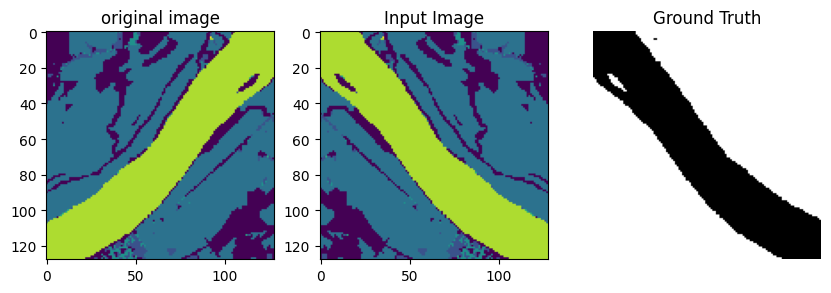

In [15]:
# test the augmentation

augmneted_data = augment_steps(image = d_img[305].numpy() , mask = d_label[305].numpy())

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(d_img[305,:,:,6])
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(augmneted_data['image'][:,:,6])
plt.title('Input Image')
plt.subplot(1,3,3)
plt.imshow(augmneted_data['mask'].squeeze(), cmap='binary')
plt.title('Ground Truth')
plt.axis('off')
plt.show()

In [16]:
# split the dataset
from sklearn.model_selection import train_test_split

train_images , test_images , train_labels , test_labels = train_test_split(d_img.numpy() , d_label.numpy() , test_size = 0.2 , random_state = 42)

In [17]:
train_images.shape , test_images.shape , train_labels.shape , test_labels.shape

((244, 128, 128, 8), (62, 128, 128, 8), (244, 128, 128, 1), (62, 128, 128, 1))

In [18]:
# now i will just apply augmentation on training data

augmented_images = []
augmented_labels = []

for i in range(train_images.shape[0]):
  augmneted_data = augment_steps(image = train_images[i] , mask = train_labels[i])
  augmented_images.append(augmneted_data['image'])
  augmented_labels.append(augmneted_data['mask'])

# convert to tensors to be more fast in training than numpy array
train_images = tf.convert_to_tensor(np.array(augmented_images))
train_labels = tf.convert_to_tensor(np.array(augmented_labels))

# Build the Model

In [19]:
# Encoder Block

def encoder_block(inputs , num_filters):

  x = tf.keras.layers.Conv2D(num_filters , 3 , padding='same' , activation = 'relu')(inputs)

  x = tf.keras.layers.Conv2D(num_filters , 3 , padding='same' , activation = 'relu')(x)

  x = tf.keras.layers.MaxPooling2D((2,2))(x)

  return x

In [20]:
# Decoder Block
def decoder_block(inputs , skip_features , num_filters):

  x = tf.keras.layers.UpSampling2D((2,2))(inputs)

  # skip connection
  skip_features = tf.keras.layers.Resizing(x.shape[1], x.shape[2])(skip_features)

  x = tf.keras.layers.concatenate([x, skip_features] , axis=-1)

  x = tf.keras.layers.Conv2D(num_filters , 3 , padding='same' , activation = 'relu')(x)

  x = tf.keras.layers.Conv2D(num_filters , 3 , padding='same' , activation = 'relu')(x)

  return x

In [21]:
# U-net model

def UNet(input_shape = (128,128,12) , num_classes = 1):

  input = tf.keras.layers.Input(input_shape)

  # encoder blocks
  e1 = encoder_block(input , 64)
  e2 = encoder_block(e1 , 128)
  e3 = encoder_block(e2 , 256)
  e4 = encoder_block(e3 , 512)

  # Bottleneck
  b5 = tf.keras.layers.Conv2D(1024 , 3 , padding='same' , activation = 'relu')(e4)
  b5 = tf.keras.layers.Conv2D(1024 , 3 , padding='same' , activation = 'relu')(b5)

  # Decoder blocks
  d1 = decoder_block(b5 , e4 , 512)
  d2 = decoder_block(d1 , e3 , 256)
  d3 = decoder_block(d2 , e2 ,128)
  d4 = decoder_block(d3 , e1 , 64)

  # final layer
  output = tf.keras.layers.Conv2D(num_classes , 1 , activation = 'sigmoid')(d4)

  model = tf.keras.Model(inputs = input , outputs = output)

  return model

# Train Model

In [22]:
model = UNet(input_shape=train_images.shape[1:] , num_classes=1) # Updated to use UNet
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      4,672 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 16, 16,    │          0 │ max_pooling2d_3[

 Total params: 31,381,825 (119.71 MB)

 Trainable params: 31,381,825 (119.71 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# evaluation matrics
def iou(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [24]:
model.compile(
    optimizer = 'adam' ,
    loss = 'binary_crossentropy' ,
    metrics = [iou , dice_coef]
)

# Training

In [25]:
history = model.fit(
    train_images ,
    train_labels ,
    batch_size = 32 ,
    epochs = 50 ,
    validation_split = 0.2
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 117s 10s/step - dice_coef: 0.3242 - iou: 0.1970 - loss: 0.6781 - val_dice_coef: 0.3285 - val_iou: 0.1966 - val_loss: 0.5728
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 443ms/step - dice_coef: 0.4052 - iou: 0.2591 - loss: 0.4811 - val_dice_coef: 0.3826 - val_iou: 0.2366 - val_loss: 1.8323
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 442ms/step - dice_coef: 0.5934 - iou: 0.4253 - loss: 0.7410 - val_dice_coef: 0.5651 - val_iou: 0.3950 - val_loss: 0.2756
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 443ms/step - dice_coef: 0.6364 - iou: 0.4717 - loss: 0.2770 - val_dice_coef: 0.6738 - val_iou: 0.5110 - val_loss: 0.2684
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - dice_coef: 0.7285 - iou: 0.5759 - loss: 0.2645 - val_dice_coef: 0.6474 - val_iou: 0.4807 - val_loss: 0.2566
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 446ms/step - dice_coef: 0.6886 - iou: 0.5264 - loss: 0.2480 - val_dice_coef: 0.6997 - val_iou: 0.5415 - val_loss: 0.2548
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 

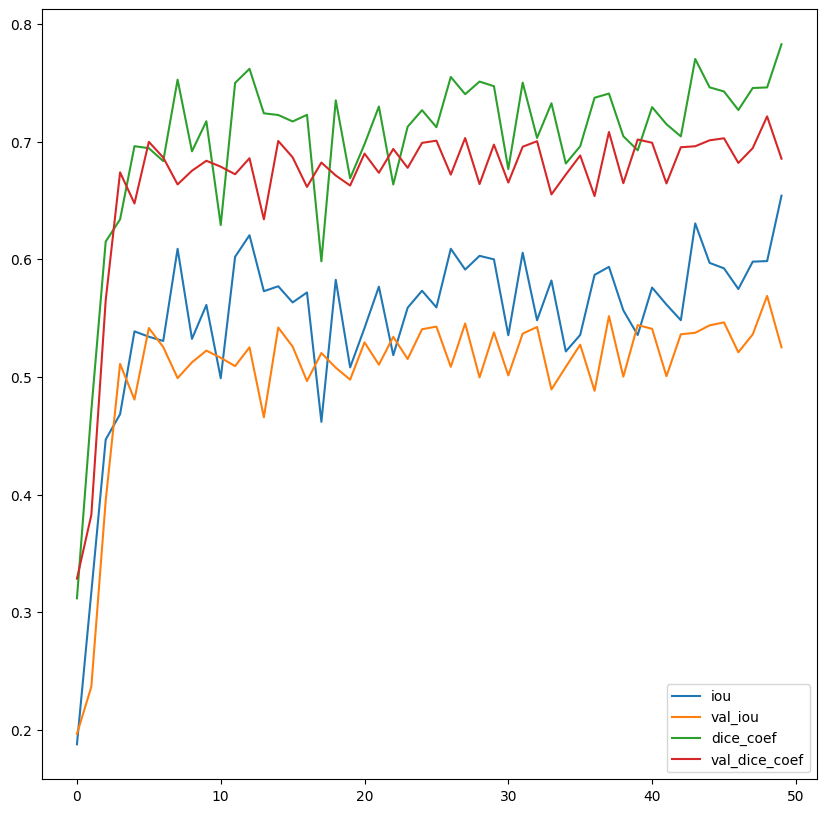

In [26]:
# plot accurecy
plt.figure(figsize=(10,10))
plt.plot(history.history['iou'] , label = 'iou')
plt.plot(history.history['val_iou'] , label = 'val_iou')
plt.plot(history.history['dice_coef'] , label = 'dice_coef')
plt.plot(history.history['val_dice_coef'] , label = 'val_dice_coef')
plt.legend()
plt.show()

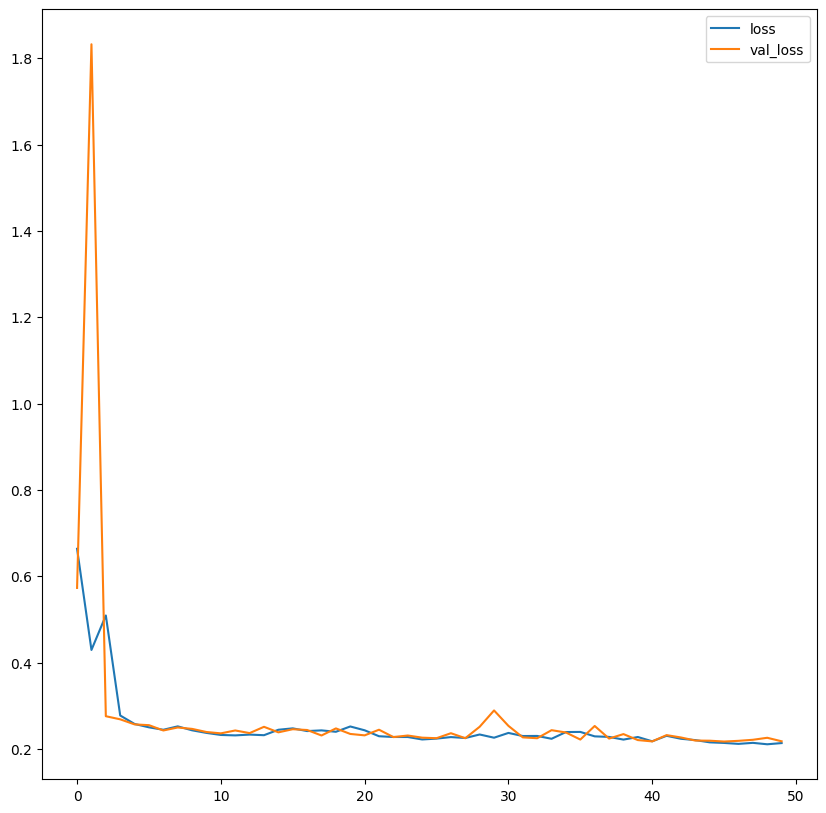

In [27]:
# plot loss
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'] , label = 'loss')
plt.plot(history.history['val_loss'] , label = 'val_loss')
plt.legend()
plt.show()

# Evaluation

In [28]:
hist_eval= model.evaluate(test_images , test_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - dice_coef: 0.7726 - iou: 0.6295 - loss: 0.2779


In [29]:
print(f"loss : {hist_eval[0]*100}")
print(f"iou : {hist_eval[1]*100}")
print(f"dice_coef : {hist_eval[2]*100}")

loss : 25.26402771472931
iou : 63.35408687591553
dice_coef : 77.55978107452393


# prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


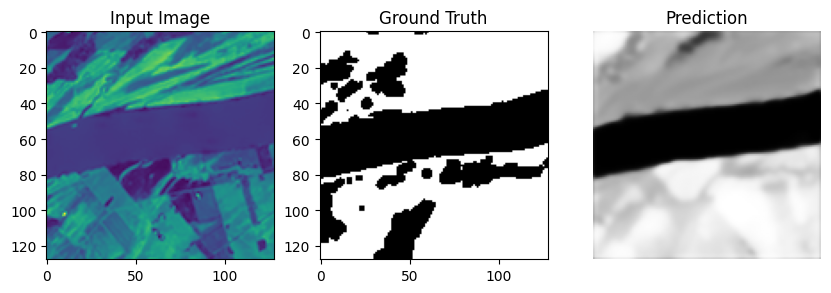

In [33]:
sample_image = test_images[1]
sample_label = test_labels[1]

# Add a batch dimension to the sample image
sample_image = tf.expand_dims(sample_image, axis=0)

prediction = model.predict(sample_image)

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(sample_image[0,:,:,0])
plt.title('Input Image')
plt.subplot(1,3,2)
plt.imshow(sample_label, cmap='binary')
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(prediction.squeeze(), cmap='binary')
plt.title('Prediction')
plt.axis('off')
plt.show()